# IPPA

## clear the workspace and configure the model

In [220]:
# clear the workspace
from IPython import get_ipython
get_ipython().magic('reset -sf')

subset_test = False

/var/folders/96/75gqgq_s2lz7zdh6kxtks3h40000gn/T/ipykernel_10446/246978568.py:3: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('reset -sf')


## get data directories

In [221]:
import os
import random
import gc
import torch
import PIL

current_path = os.getcwd()
print("current path: ", current_path)

data_file_path = os.path.join(current_path, "..", "data", "smp_2019")
print("data file path: ", data_file_path)

data_image_path = os.path.join(data_file_path, "images")
print("data image path: ", data_image_path)

images = os.listdir(data_image_path)
images = [image for image in images if image.endswith(".jpg")]
images = [image for image in images if os.path.getsize( \
    os.path.join(data_image_path, image)) > 0]
print("number of images: ", len(images))

# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: ", device)

random.seed(42)
if subset_test:
    images = random.sample(images, min(len(images), 10000))

current path:  /Users/cheye/Desktop/new_yc/projects/IPPA/scripts
data file path:  /Users/cheye/Desktop/new_yc/projects/IPPA/scripts/../data/smp_2019
data image path:  /Users/cheye/Desktop/new_yc/projects/IPPA/scripts/../data/smp_2019/images
number of images:  248464
device:  cpu


## load data

In [222]:
import pandas as pd
import numpy as np
import json

user_additional         = os.path.join(data_file_path, "user_additional.csv")
train_file_dir          = os.path.join(data_file_path, "train_all_json")
img_url_file            = os.path.join(data_file_path, "img_url.txt")

train_additional        = os.path.join(train_file_dir, "train_additional_information.json")
train_img               = os.path.join(train_file_dir, "train_img_filepath.txt")
train_label             = os.path.join(train_file_dir, "train_label.txt")

with open(train_additional) as f:
    train_additional = json.load(f)
train_additional        = pd.DataFrame(train_additional)
img_url                 = pd.read_csv(img_url_file, sep="\t", header=None)
img_url.columns         = ["url", "src"]
data                    = pd.concat([train_additional, img_url], axis=1)
with open(train_label) as f:
    train_labels = pd.read_csv(f, header=None)
train_labels.columns    = ["label"]
data                    = pd.concat([data, train_labels], axis=1)
img_names               = images
img_names               = [i.replace("_", "/", 1) for i in img_names if i.endswith(".jpg")]
img_names               = ["https://live.staticflickr.com/" + i for i \
                           in img_names if i.endswith(".jpg")]
img_names               = pd.DataFrame(img_names, columns=["src"])
data                    = pd.merge(data, img_names, on=["src"])
data["src"]         = data["src"].apply(lambda x: os.path.join( \
    data_image_path, x.replace("https://live.staticflickr.com/", "").replace("/", "_")))
data["src"]             = data["src"].apply(lambda x: os.path.abspath(x))

data = data[["src", "label"]]
data = data.rename(columns={"src": "img_path"})
del data_file_path, data_image_path, images, user_additional
del train_file_dir, img_url_file, train_additional, train_img
del train_label, img_url, train_labels, img_names, current_path, f
gc.collect()

print("data:\n", data.head(1).to_string())

data:
                                                                                       img_path  label
0  /Users/cheye/Desktop/new_yc/projects/IPPA/data/smp_2019/images/161_385070026_396c358301.jpg  11.18


## classification

In [223]:
import torch
from mmpretrain import get_model
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.transforms import functional as F
from PIL import Image
import tqdm

model = get_model('efficientnet-b0_3rdparty_8xb32_in1k', pretrained=True).to(device)

class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        image = Image.open(img_path).convert('RGB')
        label = self.dataframe.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = CustomDataset(dataframe=data, transform=transform)

data_loader = DataLoader(dataset, batch_size=32, shuffle=False)

model.eval()
outputs = []

with torch.no_grad():
    for inputs, labels in tqdm.tqdm(data_loader):
        inputs = inputs.to(device)
        results = model(inputs)
        _, preds = torch.max(results, 1)
        outputs.append(preds.cpu())

preds = torch.cat(outputs, dim=0)

del data_loader, inputs, labels, results, outputs, transform
del dataset, model, CustomDataset, DataLoader, transforms
gc.collect()

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmclassification/v0/efficientnet/efficientnet-b0_3rdparty_8xb32_in1k_20220119-a7e2a0b1.pth


100%|██████████| 7765/7765 [6:19:59<00:00,  2.94s/it]  


86

## Count different classification results.

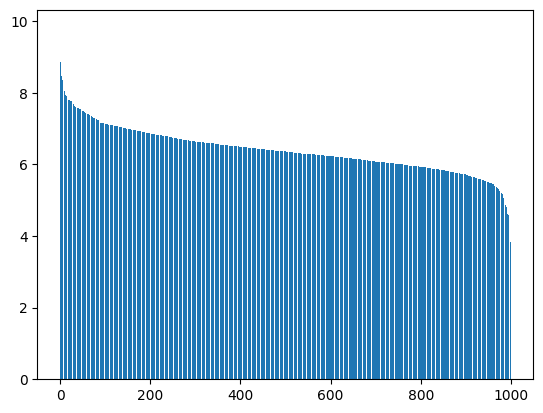

In [236]:
from collections import Counter
import matplotlib.pyplot as plt

# save preds
# np.save("../data/smp_2019/preds_all.npy", preds.numpy())
preds = torch.from_numpy(np.load("../data/smp_2019/preds_all.npy"))

type_counter = Counter(preds.numpy())
type_sum = Counter()

for i, (img, label) in enumerate(data.values):
    type_sum[preds[i].item()] += label

type_sum = dict(type_sum)
type_counter = dict(type_counter)

type_sum = {k: v / type_counter[k] if type_counter[k] > 0 else 0 for k, v in type_sum.items()}

x = type_sum.keys()
x = list(x)
x.sort()

y = type_sum.values()
y = list(y)
y.sort(reverse=True)

plt.bar(x, y)
plt.show()